**Import Libraries**

In [1]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from PIL import Image
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import corpus_bleu

**Define Directories**

In [2]:
BASE_DIR = r'C:\Users\victus\Downloads\archive'
WORKING_DIR = r'C:\Users\victus\OneDrive\Desktop\AI'

**Load and Restructure VGG16 Model**

In [3]:
model = VGG16()
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
print(model.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None


**Extract Features from Images**

In [ ]:
features = {}
directory = os.path.join(BASE_DIR, 'Images')

for img_name in tqdm(os.listdir(directory)):
    img_path = os.path.join(directory, img_name)
    
    # Load and preprocess image
    image = load_img(img_path, target_size=(224, 224))  # Load image with target size
    image = img_to_array(image)                        # Convert to NumPy array
    image = np.expand_dims(image, axis=0)              # Add batch dimension
    image = preprocess_input(image)                    # Preprocess for VGG16

    # Extract features using the model
    feature = model.predict(image, verbose=0)
    image_id = img_name.split('.')[0]
    features[image_id] = feature

# Save the extracted features
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

  0%|          | 0/8091 [00:00<?, ?it/s]

**Load Captions and Create Mapping**

In [ ]:
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

mapping = {}
for line in tqdm(captions_doc.split('\n')):
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    image_id = image_id.split('.')[0]
    caption = " ".join(caption)
    if image_id not in mapping:
        mapping[image_id] = []
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

**Preprocess Captions**

In [ ]:
import re

def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            caption = captions[i].lower()
            # Remove non-alphabetic characters using regex
            caption = re.sub(r'[^a-z]', ' ', caption)
            # Replace multiple spaces with a single space
            caption = re.sub(r'\s+', ' ', caption)
            # Add start and end sequence tokens
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word) > 1]) + ' endseq'
            captions[i] = caption

clean(mapping)

**Tokenize Captions**

In [10]:
all_captions = [caption for captions in mapping.values() for caption in captions]
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in all_captions)

**Split Dataset**

In [11]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

**Data Generator Function**

In [12]:
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    X1, X2, y = [], [], []
    n = 0
    while True:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            for caption in captions:
                seq = tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                yield {"image": np.array(X1), "text": np.array(X2)}, np.array(y)
                X1, X2, y = [], [], []
                n = 0

**Define and Compile Model**

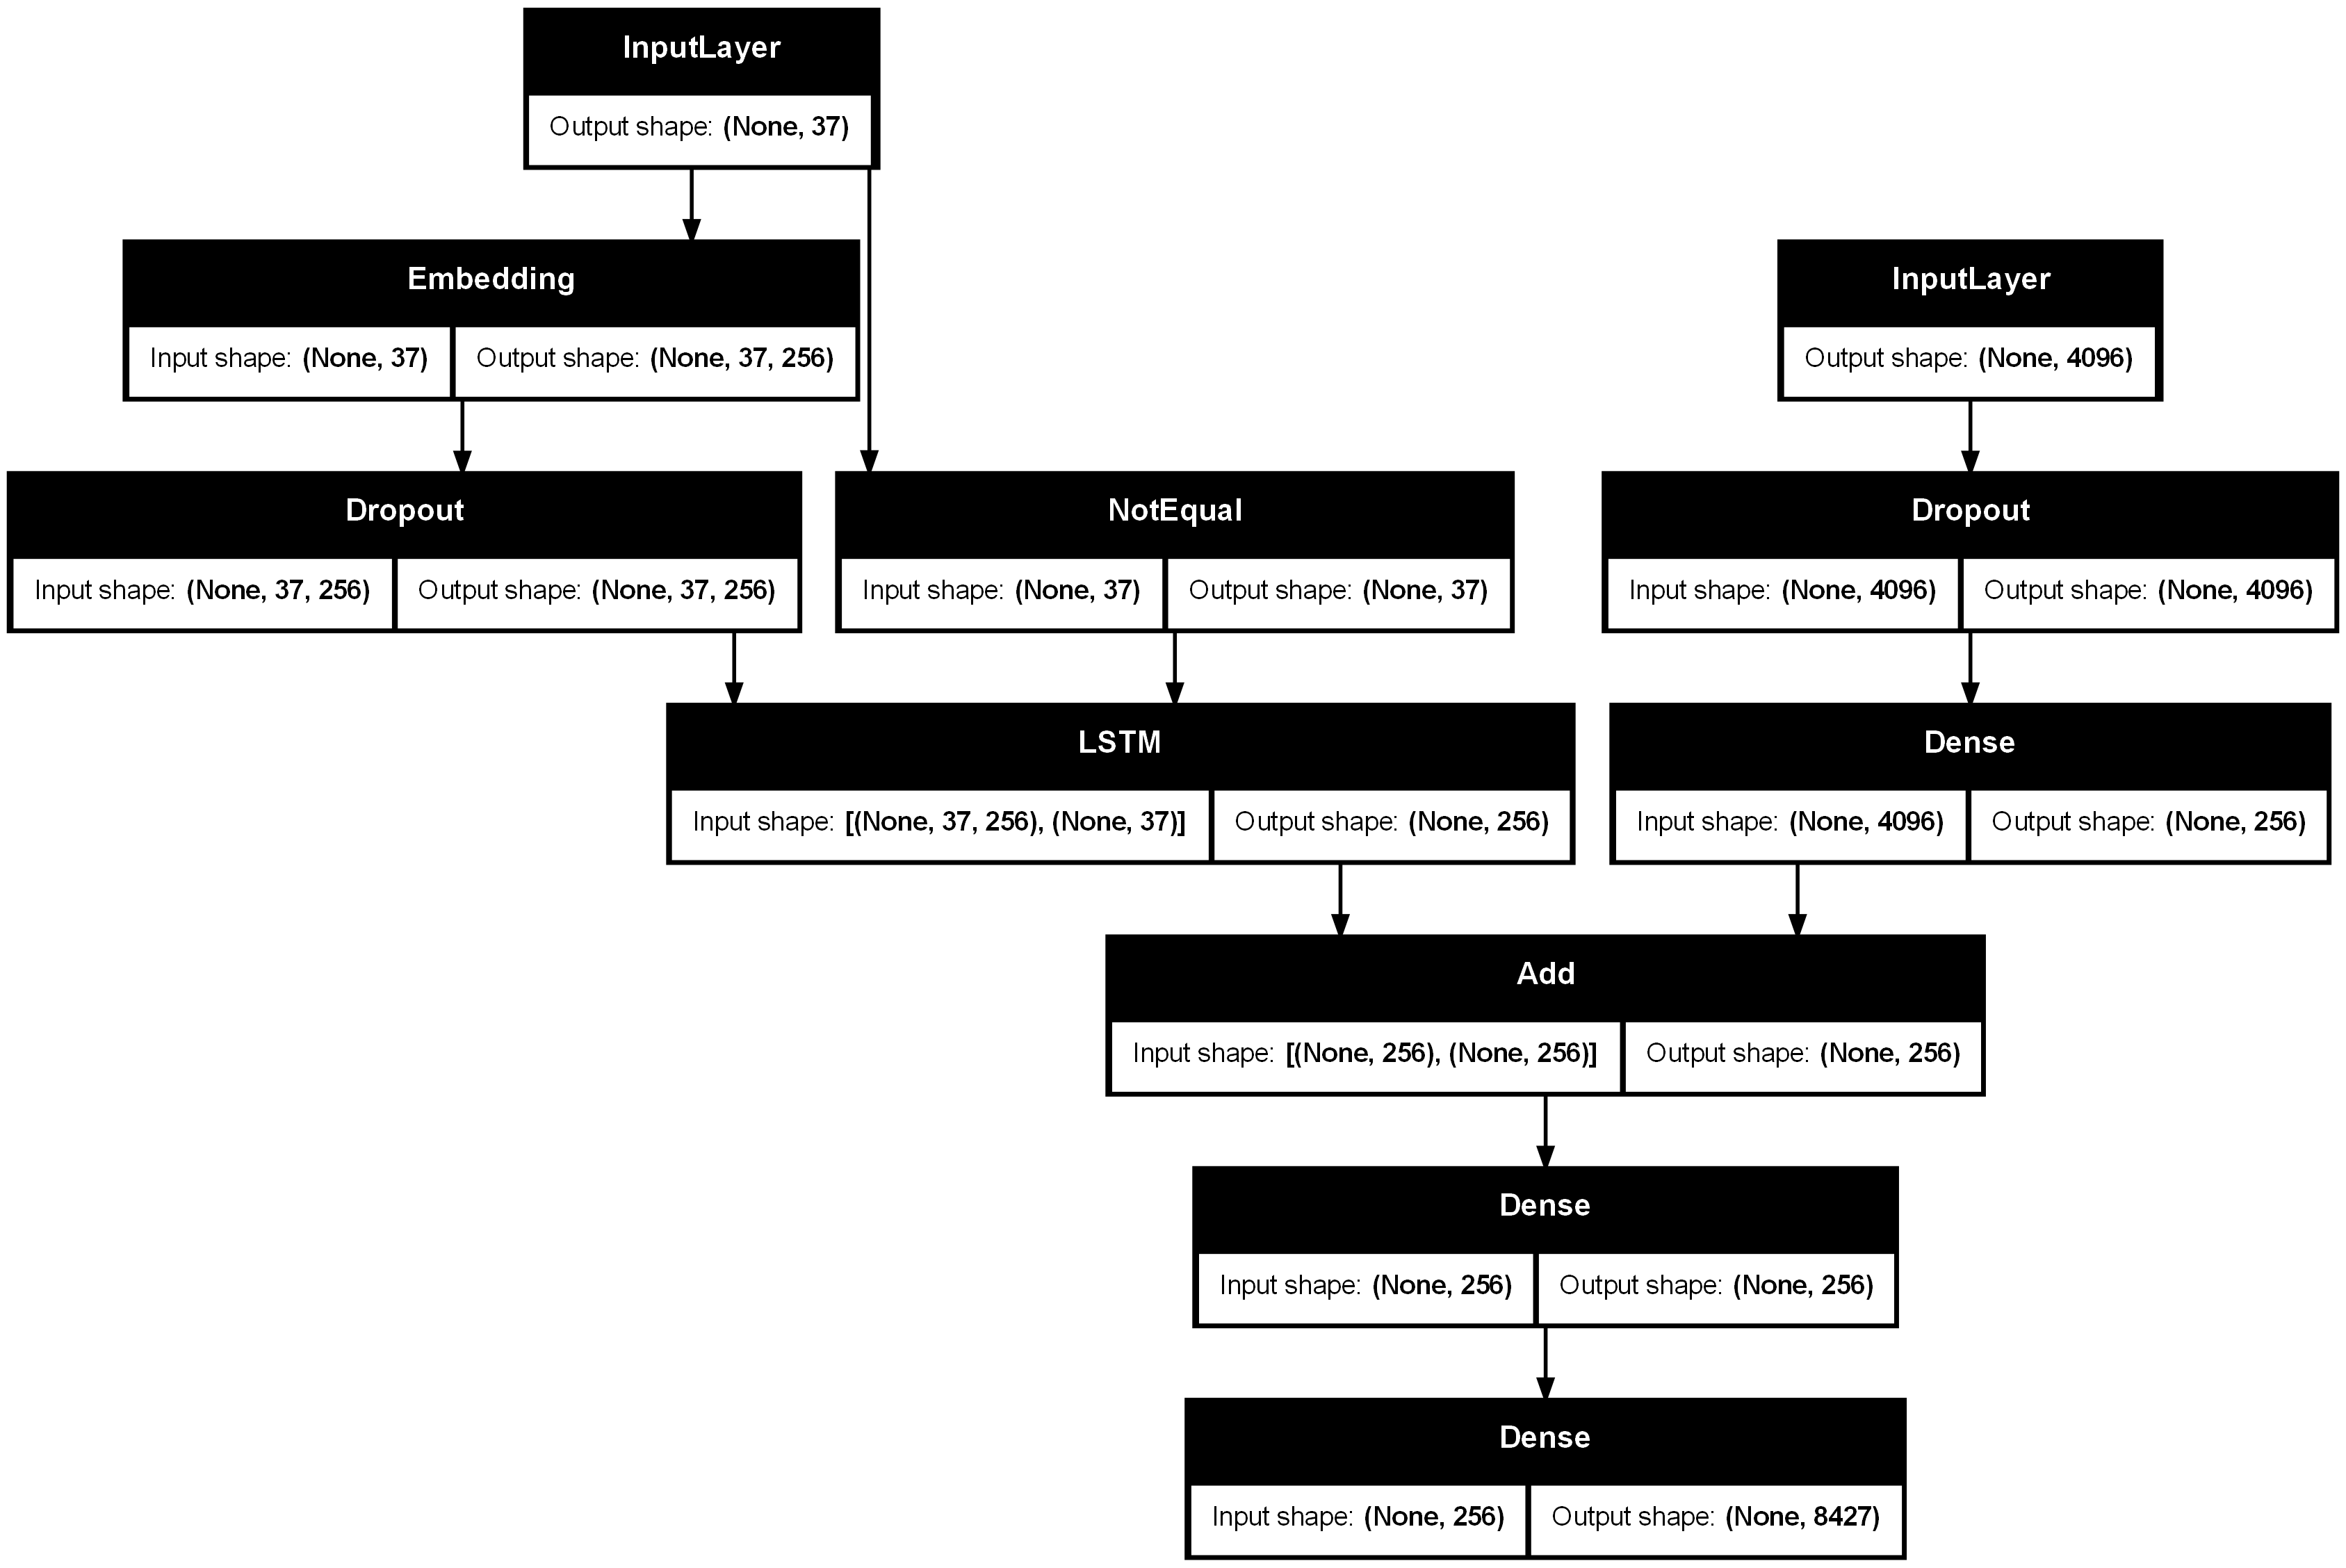

In [13]:
inputs1 = Input(shape=(4096,), name="image")
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

inputs2 = Input(shape=(max_length,), name="text")
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')
plot_model(model, show_shapes=True)

**Train the Model**

In [ ]:
epochs = 20
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

# Save the model using the recommended Keras format
model.save(os.path.join(WORKING_DIR, 'best_model.keras'))


227/227 ━━━━━━━━━━━━━━━━━━━━ 2831s 12s/step - loss: 1.8227
227/227 ━━━━━━━━━━━━━━━━━━━━ 2925s 13s/step - loss: 1.7999
227/227 ━━━━━━━━━━━━━━━━━━━━ 3020s 13s/step - loss: 1.7821
227/227 ━━━━━━━━━━━━━━━━━━━━ 3169s 14s/step - loss: 1.7630
227/227 ━━━━━━━━━━━━━━━━━━━━ 3187s 14s/step - loss: 1.7451
227/227 ━━━━━━━━━━━━━━━━━━━━ 3262s 14s/step - loss: 1.7284
227/227 ━━━━━━━━━━━━━━━━━━━━ 3337s 15s/step - loss: 1.7134
227/227 ━━━━━━━━━━━━━━━━━━━━ 3441s 15s/step - loss: 1.6968
227/227 ━━━━━━━━━━━━━━━━━━━━ 3519s 16s/step - loss: 1.6835
227/227 ━━━━━━━━━━━━━━━━━━━━ 3557s 16s/step - loss: 1.6713
227/227 ━━━━━━━━━━━━━━━━━━━━ 3628s 16s/step - loss: 1.6558
227/227 ━━━━━━━━━━━━━━━━━━━━ 3755s 17s/step - loss: 1.6454
227/227 ━━━━━━━━━━━━━━━━━━━━ 3815s 17s/step - loss: 1.6359
227/227 ━━━━━━━━━━━━━━━━━━━━ 6757s 30s/step - loss: 1.6240
227/227 ━━━━━━━━━━━━━━━━━━━━ 7120s 31s/step - loss: 1.6147
227/227 ━━━━━━━━━━━━━━━━━━━━ 5200s 23s/step - loss: 1.5997
227/227 ━━━━━━━━━━━━━━━━━━━━ 4292s 19s/step - loss: 1.58

**Define Prediction and Evaluation Functions**

In [16]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

def predict_caption(model, image, tokenizer, max_length):
    in_text = 'startseq'
    for _ in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)
        yhat = model.predict([image, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = idx_to_word(yhat, tokenizer)
        if word is None:
            break
        in_text += " " + word
        if word == 'endseq':
            break
    return in_text

**Evaluate Model with BLEU Scores**

In [17]:
actual, predicted = [], []

for key in tqdm(test):
    captions = mapping[key]
    y_pred = predict_caption(model, features[key], tokenizer, max_length).split()
    actual.append([caption.split() for caption in captions])
    predicted.append(y_pred)

print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.562067
BLEU-2: 0.373719


**Save tokenizer**

In [20]:
with open(os.path.join(WORKING_DIR, 'tokenizer.pkl'), 'wb') as f:
    pickle.dump(tokenizer, f)

**Caption Generation with Visualization**

---------------------Actual---------------------
startseq startseq brown and black dog is standing on its hind legs trying to catch something endseq endseq
startseq startseq dog is jumping up on hind legs with its mouth open endseq endseq
startseq startseq dog plays on the grass endseq endseq
startseq startseq german shepherd playing with water in the grass endseq endseq
startseq startseq german shepherd standing up snapping at droplets of water endseq endseq
--------------------Predicted--------------------
startseq startseq brown dog is running through the grass endseq


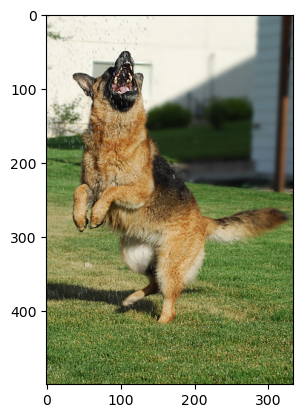

In [ ]:
def generate_caption(image_name):
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

generate_caption("888517718_3d5b4b7b43.jpg")